In [2]:
import matplotlib.pyplot as plt
import numpy as np
from Dataset import load_scg, load_scg_template
from decompose import *
from add_noises import *

In [11]:
import numpy as np
from PyEMD import EEMD, EMD
from vmdpy import VMD
from statsmodels.tsa.seasonal import seasonal_decompose
from utils import plot_decomposed_components
import matplotlib.pyplot as plt

def standize_1D(signal):
    return (signal - signal.mean()) / signal.std()

def emd_decomposition(signal, show=False):
    signal = standize_1D(signal)
    emd = EMD()
    imfs = emd(signal)
    if show:
        plot_decomposed_components(signal, imfs, 'EMD')
    return imfs

def eemd_decomposition(signal, noise_width=0.05, ensemble_size=100, show=False):
    signal = standize_1D(signal)
    eemd = EEMD(trails=ensemble_size, noise_width=noise_width)
    imfs = eemd.eemd(signal)
    if show:
        plot_decomposed_components(signal, imfs, 'EEMD')
    return imfs

def vmd_decomposition(signal, K=5, alpha=2000, tau=0, DC=0, init=1, tol=1e-7, show=False):
    """
    K: how many modes
    alpha: moderate bandwidth constraint
    tau: noise-tolerance (no strict fidelity enforcement)
    DC: whether have DC part imposed
    init: initialize omegas uniformly
    tol:

    Reference: link: https://vmd.robinbetz.com/
    """
    signal = standize_1D(signal)
    u, _, _ = VMD(signal, alpha, tau, K, DC, init, tol)
    if show:
        plot_decomposed_components(signal, u, 'VMD')
    return u

def seasonal_decomposition(signal, period=100, model=0, show=False):
    """
    Parameters:
    model(int) : 0->"addative" or 1->"multiplicative"
    period : Period of the series.
    returns :
    results: get values of results by
    result.seasonal, result.trend, result.resid
    """
    signal = standize_1D(signal)

    stl_model = None
    if model == 0:
        stl_model = "addative"
    elif model == 1:
        stl_model = "multiplicative"
    components = seasonal_decompose(signal, model=stl_model, period=period)

    if show:
        plt.subplots(4, 1)

        plt.subplot(4, 1, 1)
        plt.plot(signal, label='Original Signal', color='r')
        plt.title("Seasonal Decomposition")
        plt.legend()

        plt.subplot(4, 1, 2)
        plt.plot(components.trend, label='Trend')
        plt.legend()

        plt.subplot(4, 1, 3)
        plt.plot(components.seasonal, label='Seasonal')
        plt.legend()

        plt.subplot(4, 1, 4)
        plt.plot(components.resid, label='Resident')
        plt.legend()
        plt.show()

    return components


In [12]:
import numpy as np
from scipy.signal import butter
from sim_waves import sine_wave
import copy
from utils import plot_noise_signal
"""
可能潜藏着的问题：
1. 生成的噪声是否需要考虑noise_freq和nosie_duration
2. 1/f, colored, thermal noise的大小范围应该有什么来控制呢? 手动输入数值还是像powerline一样 由signal_sd来控制?
3. impulse noise的实现是否能再优化一下
4. transient noise究竟该如何实现
"""


def add_white_noise(
        signal,  noise_amplitude=0.1, model=0, show=False
        ):
    """maybe need to check the nyquist
    if model == 0: gaussian noise
    if model == 1: laplace noise
    """
    signal_sd = np.std(signal, ddof=1)
    amp = signal_sd * noise_amplitude

    _noise = 0
    if model == 0:
        _noise = np.random.normal(0, amp, len(signal))
    elif model == 1:
        _noise = np.random.laplace(0, amp, len(signal))

    noisy_signal = _noise + signal

    if show:
        plot_noise_signal(signal, noisy_signal, 'Add White Noise')

    return noisy_signal


# 和上面的白噪声一样，没有考虑过noise_freq和noise_duration，可能后期需要大改
def add_band_limited_white_noise(
    signal, noise_amplitude=0.1, sampling_rate=100, lowcut=0.1, highcut=5, order=4, show=False
    ):
    # Generate white noise
    signal_sd = np.std(signal, ddof=1)
    amp = signal_sd * noise_amplitude
    _noise = np.random.normal(0, amp, len(signal))

    # Define bandpass filter parameters
    b, a = butter(order, [lowcut, highcut], btype='band', fs=sampling_rate)

    _band_limited_noise = signal.lfilter(b, a, _noise)
    noisy_signal = _band_limited_noise + signal

    if show:
        plot_noise_signal(signal, noisy_signal, 'Add Band-limited White Noise')

    return noisy_signal

def add_impulsive_noise(
    signal, noise_amplitude=0.1, rate=None, number=None, show=False
):
    signal_sd = np.std(signal, ddof=1)
    amp = signal_sd * noise_amplitude
    num_samples = len(signal)

    # rate or number
    if rate is not None and number is None:
        pob = [1 - rate, rate]
    elif rate is None and number is not None:
        pob_rate = number / num_samples
        if pob_rate >= 1.0:
            pob_rate = 1
        pob = [1 - pob_rate, pob_rate]
    else:
        return None

    impulsive_noise = np.random.choice([0, 1], size=num_samples, p=pob) * np.random.normal(0, amp, num_samples)
    noisy_signal = impulsive_noise + signal
    if show:
        plot_noise_signal(signal, noisy_signal, 'Add Impulsive Noise')

    return noisy_signal

def add_burst_noise(
        signal, noise_amplitude=0.1, burst_num_max=1, burst_durations=[10, 50], burst_intervals=[100, 300], show=False):

    signal_length = len(signal)

    _noise = np.zeros(signal_length)
    signal_sd = np.std(signal, ddof=1)

    amp = noise_amplitude * signal_sd

    burst_start = np.random.randint(0, (signal_length - burst_durations[1] + 1 )// burst_num_max)

    for _ in range(burst_num_max):
        burst_duration = np.random.uniform(burst_durations[0], burst_durations[1])
        burst_end = burst_start + burst_duration

        if burst_end >= signal_length:
            break

        burst_interval = np.random.uniform(burst_intervals[0], burst_intervals[1])
        burst_start = burst_end + burst_interval

        _noise[burst_start: burst_end] += np.random.normal(0, amp)
    noisy_signal = _noise + signal
    if show:
        plot_noise_signal(signal, noisy_signal, 'Add Burst Noise')

    return noisy_signal

def spectral_density(frequency_range, magnitude=1, noise_exponent=1, show=False):
    """
    Calculate the spectral density of pink noise.

    Parameters:
        frequency_range (array-like): Array of positive frequencies.
        Magnitude (float): Magnitude of the noise.
        noise_exponent (float): Exponent determining the slope of the spectral density.

    Returns:
        array: Spectral density values.
    """
    return magnitude / (frequency_range ** noise_exponent)

def add_colored_noise(
        sampling_rate=100, duration=10, noise_max=1, model=0, show=False):
    """
    Generate colored noise using the specified parameters.

    Parameters:
        sampling_rate (int): Sampling rate of the audio signal.
        duration (float): Duration of the colored noise signal in seconds.
        Magnitude (float): Magnitude of the noise.
        noise_exponent (float): Exponent determining the slope of the spectral density.
        noise_max (float): Maximum desired amplitude of the colored noise.
        model(int): 0->'pink' 1->'brown'
    Returns:
        array: Generated colored noise signal.
    """

    if model == 0:
        # pink
        noise_exponent = 1
        magnitude = 1
    elif model == 1:
        # brown
        noise_exponent = 2
        magnitude = 1

    num_samples = int(sampling_rate * duration)
    frequency_range = np.fft.fftfreq(num_samples)[1: num_samples // 2]

    # Calculate spectral density using the provided function
    _spectral_density = spectral_density(frequency_range, magnitude, noise_exponent)

    # Generate random phases for each frequency component
    random_phases = np.random.uniform(0, 2 * np.pi, len(frequency_range))

    # Combine magnitude and phases to form the complex spectrum
    spectrum = np.sqrt(_spectral_density) * np.exp(1j * random_phases)

    # Perform inverse FFT to convert complex spectrum to time-domain signal
    _colored_noise = np.fft.irfft(spectrum, n=num_samples)

    # Scale the colored noise to achieve the desired maximum amplitude
    scaling = _colored_noise.max() / noise_max
    _colored_noise /= scaling
    noisy_signal = _colored_noise + signal
    if show:
        plot_noise_signal(signal, noisy_signal, 'Add Colored Noise')
    return noisy_signal


def add_flicker_noise(
        signal, sampling_rate=100, duration=10, magnitude=1, noise_exponent=1, noise_max=1, show=False):

    num_samples = int(sampling_rate * duration)
    frequency_range = np.fft.fftfreq(num_samples)[1: num_samples // 2]

    # Calculate spectral density using the provided function
    _spectral_density = spectral_density(frequency_range, magnitude, noise_exponent)

    # Generate random phases for each frequency component
    random_phases = np.random.uniform(0, 2 * np.pi, len(frequency_range))

    # Combine magnitude and phases to form the complex spectrum
    spectrum = np.sqrt(_spectral_density) * np.exp(1j * random_phases)

    # Perform inverse FFT to convert complex spectrum to time-domain signal
    _flicker_noise = np.fft.irfft(spectrum, n=num_samples)

    # Scale the flicker noise to achieve the desired maximum amplitude
    scaling = _flicker_noise.max() / noise_max
    _flicker_noise /= scaling
    noisy_signal = _flicker_noise + signal
    if show:
        plot_noise_signal(signal, noisy_signal, 'Add Flicker Noise')
    return noisy_signal


def add_thermal_noise(
        sampling_rate=100, duration=10, Temperature=100, noise_max=1, show=False):

    num_samples = int(sampling_rate * duration)
    frequency_range = np.fft.fftfreq(num_samples)[1: num_samples // 2]

    # Calculate spectral density
    k = 1.38e-23 # Boltzmann constant
    _spectral_density = k * Temperature / 2

    # Generate random phases for each frequency component
    random_phases = np.random.uniform(0, 2 * np.pi, len(frequency_range))

    # Combine magnitude and phases to form the complex spectrum
    spectrum = np.sqrt(_spectral_density) * np.exp(1j * random_phases)

    # Perform inverse FFT to convert complex spectrum to time-domain signal
    _thermal_noise = np.fft.irfft(spectrum, n=num_samples)

    # Scale the thermal noise to achieve the desired maximum amplitude
    scaling = _thermal_noise.max() / noise_max
    _thermal_noise /= scaling
    noisy_signal = _thermal_noise + signal
    if show:
        plot_noise_signal(signal, noisy_signal, 'Add Thermal Noise')
    return noisy_signal

def add_powerline_noise(
    signal, sampling_rate=100, duration=10, powerline_frequency=50, powerline_amplitude=0.1, show=False
):
    nyquist = sampling_rate * 0.5
    if powerline_frequency > nyquist:
        return np.zeros(len(signal))

    signal_sd = np.std(signal, ddof=1)
    time = np.linsapce(0, duration, duration * sampling_rate)

    powerline_noise = sine_wave(time=time, Amplitude=1, frequency=powerline_frequency, phase=0)

    powerline_amplitude *= signal_sd
    powerline_noise *= powerline_amplitude
    noisy_signal = powerline_noise + signal
    if show:
        plot_noise_signal(signal, noisy_signal, 'Add Powerline Noise')
    return noisy_signal

def add_echo_noise(
        signal, n_echo=5, attenuation_factor=[0.5,0.4,0.3,0.2,0.1], delay_factor=[5]*5, show=False
):
    if type(attenuation_factor) != list and type(attenuation_factor) != np.ndarray:
        raise ValueError("type of attenuation_factor must be list or numpy.ndarray")
    if type(delay_factor) != list and type(delay_factor) != np.ndarray:
        raise ValueError("type of delay_factor must be list or numpy.ndarray")

    if len(attenuation_factor) != n_echo or len(delay_factor) != n_echo:
        raise ValueError("len(attenuation_factor) and len(delay_factor) should be equal to n_echo")

    original_signal = signal.copy()
    for a_factor, d_factory in zip(attenuation_factor, delay_factor):
        attenuation_signal = original_signal * a_factor
        print(attenuation_signal[d_factory:].shape)
        print(attenuation_signal[:-d_factory].shape)
        attenuation_signal[d_factory:] = attenuation_signal[:-d_factory]
        attenuation_signal[:d_factory] = 0
        original_signal += attenuation_signal
    noisy_signal = original_signal + signal
    if show:
        plot_noise_signal(signal, noisy_signal, 'Add Echo Noise')
    return noisy_signal

def add_click_noise(
        signal, noise_amplitude=0.1, n_click=5, show=False
):

    signal_sd = np.std(signal, ddof=1)
    amp = signal_sd * noise_amplitude
    noise_pos = (np.random.uniform(0, len(signal), n_click)).astype(int)
    mask = np.zeros(len(signal))
    mask[noise_pos] = 1
    _click_noise = np.random.normal(0, amp, len(signal)) * mask
    noisy_signal = _click_noise + signal
    if show:
        plot_noise_signal(signal, noisy_signal, 'Add Click Noise')
    return noisy_signal


In [2]:
signals_train, labels_train, duration, fs =  load_scg_template(0.1, 'train')
signals_test, labels_test, duration, fs =  load_scg_template(0.1, 'test')

add_white_noise(signal=scg,show=true)
eemd_decomposition(signal=scg,show=true)


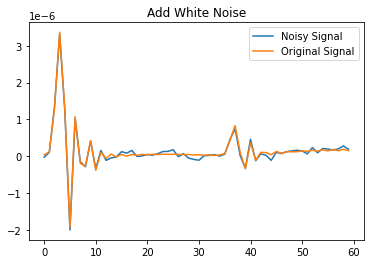

[-2.86795810e-08  1.05679453e-07  1.34053653e-06  3.31507425e-06
  1.23738696e-06 -2.00649615e-06  1.01229422e-06 -1.52176113e-07
 -2.89077792e-07  4.11804251e-07 -3.39958705e-07  1.53787538e-07
 -1.15249300e-07 -4.73301582e-08 -2.32756857e-08  1.22314410e-07
  8.08979749e-08  1.53274140e-07 -9.28227262e-09  6.46087502e-09
  4.59496683e-08  2.52854010e-08  6.44686277e-08  1.23963220e-07
  1.28764917e-07  1.75455261e-07 -1.56394286e-08  6.60232501e-08
 -5.31103896e-08 -8.90924153e-08 -1.12260014e-07  1.02459911e-08
  1.90226559e-08  4.07089028e-08  6.43009244e-10  5.40038198e-08
  4.39611648e-07  7.47850056e-07  1.18123373e-08 -3.27578961e-07
  4.56921459e-07 -1.24181218e-07  6.27756323e-08  2.32542382e-08
 -1.14340547e-07  1.01682781e-07  7.04108714e-08  1.20851013e-07
  1.42389422e-07  1.59141827e-07  1.45197690e-07  6.04654374e-08
  2.32812486e-07  9.08268290e-08  2.06929584e-07  1.93167375e-07
  1.67012719e-07  1.97070760e-07  2.76293511e-07  1.87074601e-07]


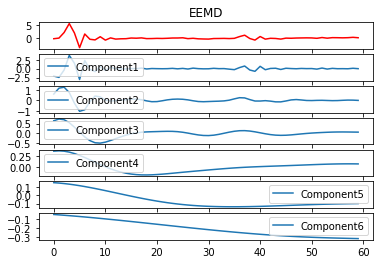

[[-2.08531913e+00 -2.45656161e+00 -3.86793548e-01  3.70921781e+00
   1.51110122e+00 -3.03913753e+00  2.27674556e+00 -2.17815174e-01
  -8.47593388e-01  5.40082490e-01 -5.01674684e-01  4.16276536e-01
  -8.89625440e-02 -4.95317794e-02 -7.57180126e-02  2.68309063e-02
  -1.26516956e-02  1.58695972e-01 -9.90522366e-02  3.26982716e-02
  -6.69411074e-03 -2.82283136e-02 -8.91422590e-03  7.68065192e-02
  -5.51582373e-02  6.74668937e-02 -1.12285928e-01  1.40236923e-01
  -4.49782623e-03 -5.48495942e-02 -4.30053054e-02  9.01544363e-02
  -7.34344363e-03  1.35554910e-02 -1.45360350e-01 -2.84496078e-01
   2.92316540e-01  7.32583082e-01 -3.88246379e-01 -7.48861868e-01
   6.46439761e-01 -3.02705259e-01  5.30912258e-02  1.07005456e-01
  -2.36960007e-01  1.06776153e-01  2.25078460e-02 -3.18896234e-02
   5.50927308e-02  4.57115911e-03  2.32747415e-02 -1.36326762e-01
   1.63384615e-01 -1.24002821e-01  7.87387425e-02 -2.20398568e-02
  -7.82214208e-03 -3.70119899e-02  1.00000752e-01 -1.18729446e-02]
 [ 6.1597

In [17]:
if __name__ == '__main__':
    def check_arguments():
        pass
    def get_params(func_sequence, pattern = r'\((.*?)\)' ):
        import re

        params = {}
        # for input_str in func_sequence.split():
        for input_str in func_sequence:
            print(input_str)
            match = re.search(pattern, input_str)
            if match:
                parameters_str = match.group(1)
                parameters_list = parameters_str.split(',')
                parameters_list = [param.strip() for param in parameters_list]
                if parameters_list == ['']:
                    parameters_dic = None
                else:
                    parameters_dic = {}
                    for paramters in parameters_list:
                        check_arguments()
                        paramters_splits = paramters.split('=')
                        if paramters_splits[0] == 'signal':
                            continue
                        if paramters_splits[0] == 'show':
                            parameters_dic[paramters_splits[0]] = True if paramters_splits[-1] == 'true' else False
                            continue
                        parameters_dic[paramters_splits[0]] = int(paramters_splits[-1])
                params[input_str.split('(')[0]] = parameters_dic
            else:
                params[input_str] = None
        return params

    def check_data_source(data_source):
        data_sources = ['scg']
        if data_source in data_sources:
            return True
        else:
            print(data_source, data_sources)
            return False

    def check_callable(func_name):
        func = globals()[func_name]
        if func is not None and callable(func):
            return True
        else:
            print(f"函数 '{func_name}' 未找到或不可调用。")
            print(f"")
            return False

    def load_data(data_source):
        # it is an easy implement
        signals_train, labels_train, duration, fs =  load_scg_template(0.1, 'train')
        return signals_train[0]

    def check_func_types(funcname_params):
        transformers= []
        estimators = []
        pass


    while True:

        inputs = input("Enter sth").lower().split(' ')

        # quit
        if inputs[0] in ['q', 'quit']:
            print('quit')
            break
        if 'q' in inputs or 'quit' in inputs:
            print('quit')
            break

        # help
        if inputs[0] in ['h', 'help']:
            for i in range(1, len(inputs)):
                func_name = inputs[i]
                print(help(globals()[func_name]))
            continue

        if inputs[0] in ['s', 'save']:
            pass

        middle_res = None

        if not check_data_source(inputs[0]):
            print(inputs[0])
            print('data source error')
            continue
            # break
        else:
            data_source = inputs[0]
            middle_res = load_data(data_source)


        funcname_params = get_params(inputs[1:])

        # if not check_func_types(funcname_params):
        #     print('func type error')
        #     continue
            # break

        # iterate dic
        for func_name, params in funcname_params.items():
            """
            # 1. def data_source = ['scg'] and check data source
            # 2. get {func_name->str, {parameter_1->str: para_1->str / number}} & check if all parameters follow the Key Word arguments
            # 3. check if func_name is callable
            # 4. check if all parameters as same as the functions' parameters name
            6. check if the next function can accept the output of the previous function as the input
            """

            if not check_callable(func_name):
                break
            func = globals()[func_name]
            params['signal'] = middle_res
            middle_res = func(**params)
            print(middle_res)




In [ ]:
# scg add_white_noise(signal=scg,show=True)
# scg eemd_decomposition(signal=scg,show=True)


In [21]:
    def check_arguments():
        pass
    def get_params(func_sequence, pattern = r'\((.*?)\)' ):
        import re

        params = {}
        for input_str in func_sequence.split():
            print(input_str)
            match = re.search(pattern, input_str)
            if match:
                parameters_str = match.group(1)
                parameters_list = parameters_str.split(',')
                parameters_list = [param.strip() for param in parameters_list]
                if parameters_list == ['']:
                    parameters_dic = None
                else:
                    parameters_dic = {}
                    for paramters in parameters_list:
                        check_arguments()
                        paramters_splits = paramters.split('=')
                        parameters_dic[paramters_splits[0]] = paramters_splits[-1]
                params[input_str.split('(')[0]] = parameters_dic
            else:
                params[input_str] = None
        return params
    get_params('func0 func1() func2(a=1) func3(a=-1,b=2)')


func0
func1()
func2(a=1)
func3(a=-1,b=2)


{'func0': None,
 'func1': None,
 'func2': {'a': '1'},
 'func3': {'a': '-1', 'b': '2'}}

In [10]:
globals()

{'__name__': '__main__',
 '__doc__': 'Automatically created module for IPython interactive environment',
 '__package__': None,
 '__loader__': None,
 '__spec__': None,
 '__builtin__': <module 'builtins' (built-in)>,
 '__builtins__': <module 'builtins' (built-in)>,
 '_ih': ['',
  'import matplotlib.pyplot as plt\nimport numpy as np\nfrom Dataset import load_scg, load_scg_template',
  'import matplotlib.pyplot as plt\nimport numpy as np\nfrom Dataset import load_scg, load_scg_template\nfrom decompose import *\nfrom add_noises import *',
  'if __name__ == \'__main__\':\n\n    def check_arguments():\n        pass\n    def get_params(func_sequence, pattern = r\'\\((.*?)\\)\' ):\n        import re\n\n        params = {}\n        # for input_str in func_sequence.split():\n        for input_str in func_sequence:\n            print(input_str)\n            match = re.search(pattern, input_str)\n            if match:\n                parameters_str = match.group(1)\n                parameters_list